CLEAN NOTEBOOK (Colab) — Latvian Leaflets Topic Modeling Pipeline

What you get (in this order):
1) TF–IDF + NMF (fixed N_TOPICS=6)
2) NMF original histogram (topics 0..5)
3) NMF aggregated histogram (6 labels via dict)
4) Shared UMAP map for NMF (same UMAP used everywhere)
5) BERTopic (arbitrary number of topics)
6) BERTopic original histogram (many topics + outliers)
7) BERTopic aggregated histogram (6 labels via mapping dict)
8) Shared UMAP map for BERTopic (same UMAP)
9) Manual CSV (id, manual_topic) → histogram by year (years from ZIP filenames)
10) Compare NMF vs manual (accuracy + crosstab)
11) Compare BERTopic vs manual (accuracy + crosstab)

IMPORTANT YOU MUST EDIT:
- NMF_TOPIC_LABELS (mapping 0..5 -> your 6 blocks)
- BT_TO_BLOCK (mapping BERTopic topic IDs -> your 6 blocks)

In [1]:
#@title 0) Install deps (run once)
!pip install -q scikit-learn sentence-transformers umap-learn bertopic==0.16.0 hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.1/154.1 kB 3.2 MB/s eta 0:00:00


In [2]:
#@title 1) Upload ZIP and extract TXT files
import shutil, os, re, zipfile, io
import pandas as pd
from google.colab import files
from IPython.display import display

print("Upload ZIP (with .txt leaflets):")
uploaded = files.upload()
if not uploaded:
    raise SystemExit("No ZIP uploaded.")

zip_name = next(iter(uploaded.keys()))
if not zip_name.lower().endswith(".zip"):
    raise SystemExit("Please upload a .zip archive.")

extract_dir = "leaflets_zip"
if os.path.exists(extract_dir):
    shutil.rmtree(extract_dir)
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(io.BytesIO(uploaded[zip_name]), "r") as zf:
    zf.extractall(extract_dir)

files_list = sorted([
    os.path.join(extract_dir, f)
    for f in os.listdir(extract_dir)
    if f.lower().endswith(".txt")
])

print(f"Extracted {len(files_list)} TXT files → {extract_dir}")
if not files_list:
    raise SystemExit("ZIP contained no .txt files.")


Upload ZIP (with .txt leaflets):


Saving latvian_communist_leaflets_1934-1940.zip to latvian_communist_leaflets_1934-1940.zip
Extracted 266 TXT files → leaflets_zip


In [3]:
#@title 2) Parse corpus + minimal Latvian cleaning + year/id extraction
import re

LATVIAN_STOPWORDS = set('''
un par lai kas bet arī kā tas tādas tādi tādas tās šis šie šīs bija būs bez pie pret vai kad tad tik ar no uz
mēs jūs viņi viņas viņš viņa kuri kuras kuru kādu kādas kādi kāds viss visi visas jo vai nu gan drīz vien vēl jau
pat kāpēc kurp ne nav tiek tiekam tikt tika vairāk mazāk ļoti tikai nekā taču
'''.split())

META_STOP = {"id","file_name","title","author","date","print_run","typography_name","source","text","revl"}
STOPWORDS = LATVIAN_STOPWORDS | META_STOP

meta_re1 = re.compile(r"\ntext:\s*", flags=re.IGNORECASE)
meta_re2 = re.compile(r"\ntext\n", flags=re.IGNORECASE)

def extract_year(fn: str):
    m = re.search(r'19(3[4-9]|40)', str(fn))
    return int(m.group(0)) if m else None

def extract_doc_id(fn: str):
    fn = str(fn)
    m = re.search(r"revl-n(\d+)([a-z])?", fn, flags=re.IGNORECASE)
    if not m:
        m = re.search(r"\bn(\d+)([a-z])?\b", fn, flags=re.IGNORECASE)
    if not m:
        return None
    return str(int(m.group(1))) + (m.group(2) or "")

rows = []
for path in files_list:
    with open(path, "r", encoding="utf-8", errors="replace") as fh:
        raw = fh.read()

    parts = meta_re1.split(raw, maxsplit=1)
    if len(parts) == 2:
        body = parts[1]
    else:
        parts2 = meta_re2.split(raw, maxsplit=1)
        body = parts2[1] if len(parts2) == 2 else raw

    t = body.lower()
    t = re.sub(r"\b\d{2,}\b", " ", t)  # remove 2+ digit numbers
    t = re.sub(r"[^\w\s\-\ā\č\ē\ģ\ī\ķ\ļ\ņ\ŗ\š\ū\ž]", " ", t)
    t = re.sub(r"\s+", " ", t).strip()

    tokens = [w for w in t.split() if len(w) > 2 and w not in STOPWORDS]
    clean = " ".join(tokens)

    fn = os.path.basename(path)
    rows.append({
        "file_name": fn,
        "raw": raw,
        "text": body.strip(),
        "clean": clean,
        "year": extract_year(fn),
        "doc_id": extract_doc_id(fn),
    })

df = pd.DataFrame(rows)
print("Docs:", len(df))
display(df[["file_name","doc_id","year","clean"]].head(3))

if df["doc_id"].isna().any():
    print("WARNING: Some doc_id could not be extracted. Check filename patterns.")
    display(df[df["doc_id"].isna()][["file_name"]].head(20))

Docs: 266


,file_name,doc_id,year,clean
0,revl-n001-LKP_LKJS_Vidienas_org-5000-[1934-01-...,1,1934,cīņas uzvaras vienotā revolucionārā frontē dar...
1,revl-n002-LKP_soldiers_org-1500-[1934-01-11…].txt,2,1934,cīņas uzvaras visu zemju proletārieši savienoj...
2,revl-n003-SP_CK-unk-[…1934-01-21].txt,3,1934,visu zemju proletārieši savienojieties biedri ...


In [4]:
#@title 3) Shared embeddings + SHARED UMAP(2D) coords for ALL maps (NMF/BERTopic/Manual)
import numpy as np
from sentence_transformers import SentenceTransformer
from umap import UMAP

# One encoder for all visual maps
emb_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")

texts_for_embed = df["clean"].tolist()
embeddings = emb_model.encode(
    texts_for_embed,
    batch_size=32,
    show_progress_bar=True,
    normalize_embeddings=True
)

# One UMAP fit (2D) — used only for visualization (shared for NMF/BERTopic/Manual)
umap_vis = UMAP(n_neighbors=30, min_dist=0.15, metric="cosine", random_state=42)



coords_umap = umap_vis.fit_transform(embeddings)
df["umap_x"] = coords_umap[:, 0]
df["umap_y"] = coords_umap[:, 1]

print("Shared UMAP coords ready:", coords_umap.shape)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/9 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Shared UMAP coords ready: (266, 2)


In [5]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

YEAR_MARKERS = {
    1934: 'o', 1935: '^', 1936: 's', 1937: 'D', 1938: 'P', 1939: 'X', 1940: '*',
    None: 'x'   # nav gada
}

BLOCK_PALETTE = {
    "Labour":      "#1f77b4",
    "Aid":         "#2ca02c",
    "Youth":       "#9467bd",
    "Women":       "#d62728",
    "Foreign/War": "#ff7f0e",
    "Spain":       "#8c564b",
    "Other":       "#7f7f7f",
    "Outlier":     "#cccccc",
}

BLOCK_ORDER = ["Labour","Aid","Youth","Women","Foreign/War","Spain","Other","Outlier"]

def plot_counts_bar(series, title, xlabel="Topic", ylabel="Count", rotate_xticks=0):
    vc = series.value_counts(dropna=False)
    plt.figure(figsize=(9,5))
    plt.bar(vc.index.astype(str), vc.values)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotate_xticks)
    plt.show()

def plot_shares_by_year(df, label_col, title, palette=BLOCK_PALETTE, order=BLOCK_ORDER):
    tmp = df.dropna(subset=["year"]).copy()
    tmp[label_col] = tmp[label_col].fillna("Outlier")

    tab = tmp.pivot_table(index="year", columns=label_col, values="file_name",
                          aggfunc="count", fill_value=0)
    tab_pct = tab.div(tab.sum(axis=1), axis=0)
    tab_pct = tab_pct.reindex(columns=order, fill_value=0)

    ax = tab_pct.plot(kind="bar", stacked=True, figsize=(9,6),
                      color=[palette[c] for c in tab_pct.columns])
    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel("Share")
    ax.set_ylim(0, 1)
    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", title="Block")
    plt.show()

def plot_shared_umap_with_year_centroids(
    df, label_col, title,
    palette=BLOCK_PALETTE, order=BLOCK_ORDER,
    years_to_use=None,
    centroid_exclude=("Outlier",),
    centroid_use_only_labeled=True,
    draw_arrow=True
):
    x = df["umap_x"].values
    y = df["umap_y"].values
    labels = df[label_col].fillna("Outlier")
    years = df["year"]

    fig, ax = plt.subplots(figsize=(10,7))

    # --- scatter ---
    for blk in order:
        if blk not in palette:
            continue
        mask_blk = (labels == blk).values
        if not mask_blk.any():
            continue
        for yr, marker in YEAR_MARKERS.items():
            mask = mask_blk & (years == yr)
            if not mask.any():
                continue
            ax.scatter(
                x[mask], y[mask],
                c=palette[blk], s=65, marker=marker,
                edgecolors="k", linewidths=0.25
            )

    ax.set_title(title)
    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")

    # --- data for centroids ---
    d = df.copy()
    d[label_col] = d[label_col].fillna("Outlier")

    if centroid_use_only_labeled:
        d = d.dropna(subset=["umap_x","umap_y","year"])

    if centroid_exclude:
        d = d[~d[label_col].isin(set(centroid_exclude))].copy()

    # --- AUTO years: 1934..1940 only if present ---
    if years_to_use is None:
        target_years = list(range(1934, 1941))
        present = set(pd.to_numeric(d["year"], errors="coerce").dropna().astype(int).unique())
        years_to_use = [yr for yr in target_years if yr in present]

    centroids = []
    for yr in years_to_use:
        sub = d[d["year"] == yr]
        if len(sub) == 0:
            continue
        cx = float(sub["umap_x"].mean())
        cy = float(sub["umap_y"].mean())
        centroids.append((int(yr), cx, cy))

        ax.scatter([cx], [cy], s=220, marker="o",
                   facecolors="none", edgecolors="k", linewidths=2.0, zorder=5)

        ax.text(cx, cy + 0.015, str(int(yr)),
                ha="center", va="bottom", fontsize=12, weight="bold", zorder=6)

    centroids = sorted(centroids, key=lambda t: t[0])
    if draw_arrow and len(centroids) >= 2:
        for i in range(len(centroids) - 1):
            _, x0, y0 = centroids[i]
            _, x1, y1 = centroids[i+1]
            ax.annotate(
                "", xy=(x1, y1), xytext=(x0, y0),
                arrowprops=dict(arrowstyle="->", lw=2.0, color="k"),
                zorder=6
            )

    # --- legends ---
    counts = labels.value_counts()
    block_handles = []
    for blk in order:
        n = int(counts.get(blk, 0))
        if n == 0:
            continue
        block_handles.append(mpatches.Patch(color=palette.get(blk, "#7f7f7f"),
                                            label=f"{blk} (n={n})"))

    year_handles = []
    for yr, marker in YEAR_MARKERS.items():
        if yr is not None and not (years == yr).any():
            continue
        if yr is None and not years.isna().any():
            continue
        year_handles.append(Line2D([0],[0], marker=marker, linestyle="None", color="k",
                                   label=str(yr), markersize=7))

    plt.subplots_adjust(right=0.80)
    side_ax = fig.add_axes([0.82, 0.10, 0.16, 0.80])
    side_ax.axis("off")
    leg1 = side_ax.legend(handles=block_handles, title="Blocks",
                          loc="upper left", bbox_to_anchor=(0.0, 1.0),
                          frameon=True, fontsize=9, title_fontsize=10)
    side_ax.add_artist(leg1)
    _ = side_ax.legend(handles=year_handles, title="Year",
                       loc="upper left", bbox_to_anchor=(0.0, 0.35),
                       frameon=True, fontsize=9, title_fontsize=10)

    plt.show()

In [6]:
#@title 5) Upload MANUAL CSV (id, manual_topic) and merge (years already from ZIP)
import numpy as np

CSV_NAME = "manual_annotation_topics_2_columns.csv"  # <- your CSV must have columns: id, manual_topic
print(f"Upload manual CSV named exactly: {CSV_NAME}")
uploaded = files.upload()
if CSV_NAME not in uploaded:
    raise SystemExit(f"Upload file named exactly: {CSV_NAME}")

manual_df = pd.read_csv(CSV_NAME, dtype=str)
manual_df.columns = manual_df.columns.str.strip()

expected = {"id", "manual_topic"}
if not expected.issubset(set(manual_df.columns)):
    raise ValueError(f"CSV must contain columns: {expected}. Found: {list(manual_df.columns)}")

manual_df["id"] = manual_df["id"].astype(str).str.strip()
manual_df["manual_topic"] = manual_df["manual_topic"].astype(str).str.strip()

df = df.merge(manual_df.rename(columns={"id": "doc_id"}), on="doc_id", how="left")

missing = df["manual_topic"].isna().sum()
print("Manual rows:", len(manual_df))
print("Docs in df:", len(df))
print("Missing manual_topic after merge:", int(missing))
if missing:
    display(df[df["manual_topic"].isna()][["doc_id","file_name"]].head(30))

# normalize manual block column for plots
df["manual_block"] = df["manual_topic"].fillna("Outlier")

Upload manual CSV named exactly: manual_annotation_topics_2_columns.csv


Saving manual_annotation_topics_2_columns.csv to manual_annotation_topics_2_columns.csv
Manual rows: 266
Docs in df: 266
Missing manual_topic after merge: 0


In [7]:
#@title 6) TF–IDF vectorization
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.95)
X = vectorizer.fit_transform(df["clean"].values)
feature_names = vectorizer.get_feature_names_out()
print("TF–IDF shape:", X.shape)

TF–IDF shape: (266, 10715)


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.



=== BERTopic topics ===

Topic 0 (n=10):
  krievijas, oktobra, sprs, revolūcijas, proletariāts, darbaļaužu, proletariāta, oktobra revolūcijas, revolūcija, valsts

Topic 1 (n=10):
  karu, tautas, tautu, dzīvo, karš, latviju, miera, pasaules, jaunatne, ķīnas

Topic 2 (n=10):
  tautas, latvijas darba, sprs, latvijā, baltijas, tautu, latvju, latviju, hitlerisma, lietuvas

Topic 3 (n=8):
  komunistu, lkp, rīgas pilsētas, rīgas, pretfašisma, pilsētu, pretfašisma cīņas, strādnieku organizāciju, strādniekiem, partijas

Topic 4 (n=8):
  fašistu, valdība, jums, svētki, strādniekiem, maija, jūlijā, arodbiedrību, var, dzīves

Topic 5 (n=8):
  brīvības, vācu, sprs, tautas, centrālkomiteja, fašismu, nost, centrālkomiteja latvijas, vācijas, fašisms

Topic 6 (n=7):
  sievietes, darba sievietes, mātes, sieviešu, sieviete, bērnu, daudz, sievietēm, buržuju, ģimenes

Topic 7 (n=7):
  karu, sprs, buržuāziju, karā, intervences, karš, masu, buržuāzija, darbaļaužu, tev

Topic 8 (n=6):
  nespējas, lauku, darb

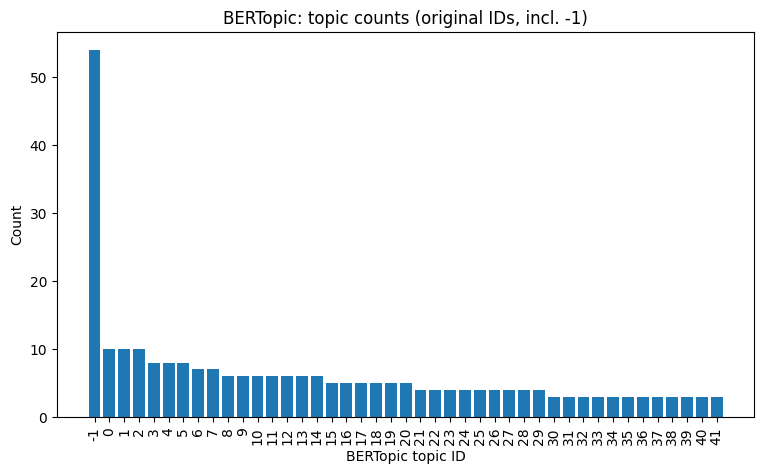

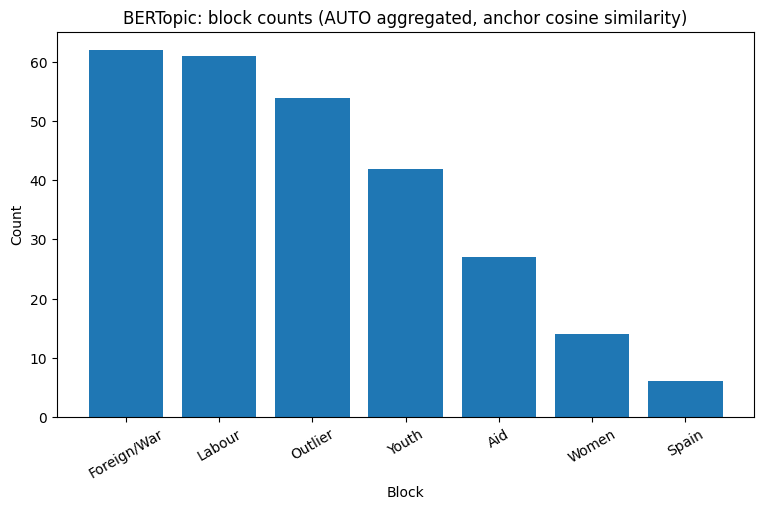

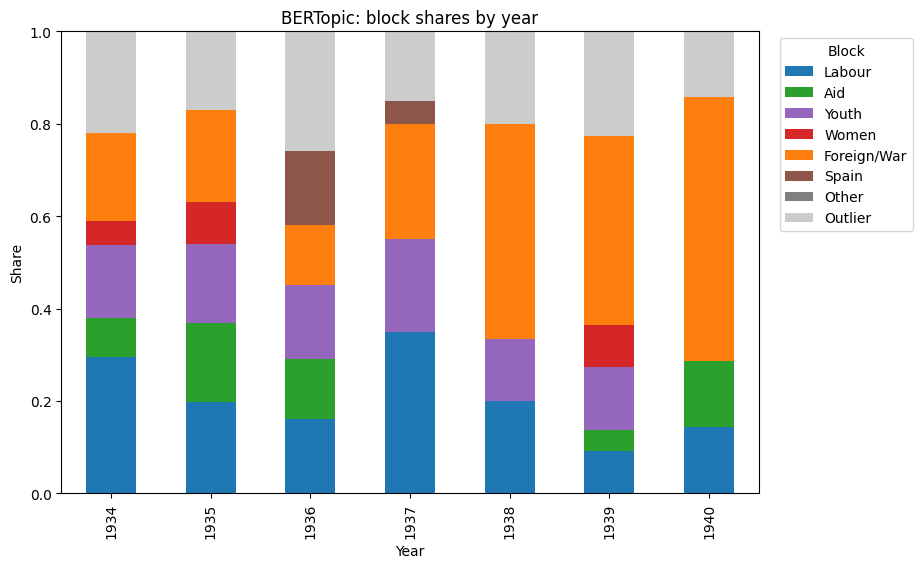

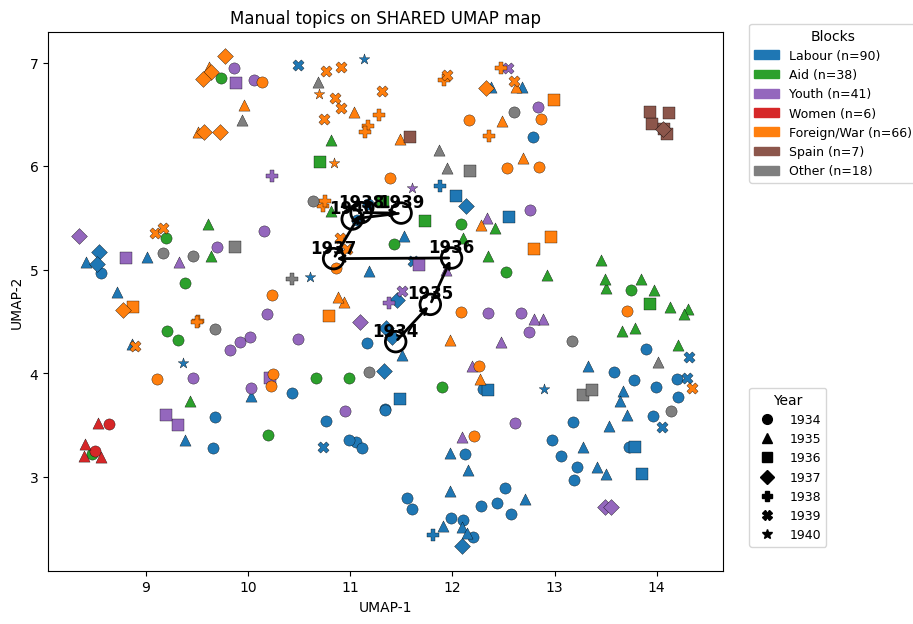

In [8]:
# --- 0) imports ---
import os, random
import numpy as np
import pandas as pd

from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from hdbscan import HDBSCAN
from umap import UMAP

# --- seeds ---
os.environ["PYTHONHASHSEED"] = "42"
random.seed(42)
np.random.seed(42)


texts_ber = df["clean"].tolist()

vectorizer_ber = CountVectorizer(
    ngram_range=(1,2),
    min_df=3,
    max_df=0.95,
    stop_words=list(STOPWORDS)
)

umap_model = UMAP(
    n_neighbors=30,
    min_dist=0.20,
    n_components=2,
    metric="cosine",
    random_state=42
)

hdbscan_model = HDBSCAN(
    min_cluster_size=3,
    min_samples=1,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True
)

topic_model = BERTopic(
    language="multilingual",
    vectorizer_model=vectorizer_ber,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    nr_topics=None,
    calculate_probabilities=True
)

bt_topics, bt_probs = topic_model.fit_transform(texts_ber)

df["bt_topic"] = bt_topics
df["bt_topic_score"] = np.nan
if bt_probs is not None:
    df["bt_topic_score"] = bt_probs.max(axis=1)

# --- 2) PRINT topics ---
TOPN = 15
print("\n=== BERTopic topics ===")
for tid in sorted(t for t in df["bt_topic"].unique() if t >= 0):
    words = topic_model.get_topic(int(tid)) or []
    top_terms = [w for (w, _) in words[:TOPN]]
    n_docs = int((df["bt_topic"] == tid).sum())
    print(f"\nTopic {tid} (n={n_docs}):")
    print(" ", ", ".join(top_terms))

# --- 3) Smart block mapping: anchors + cosine similarity (+ override Spain/Women) ---
BLOCKS = ["Labour","Aid","Youth","Women","Foreign/War","Spain"]
DEFAULT_BLOCK = "Other"

BLOCK_ANCHORS = {
    "Spain": "spānijas spānijā spāņu fronte republika franko internacionāl brigāde",
    "Women": "sievietes sieviešu mātes bērnu bērni ģimenes mājsaimniecība",
    "Youth": "jaunatne jaunatnes jaunatnei jaunietis lkjs skolnieku skolu skolas skolā student",
    "Aid": "cietumos ieslodzītie politieslodzītajiem spīdzināšana spīdzin bendes protests politpārvalde murina ventspils",
    "Labour": "strādnieku strādniekiem algas algu streikā arodbiedrību bezdarbnieku darba nespējas īres ierēdņi pašvaldību darbinieku",
    "Foreign/War": "karš karu pretkara fašisms fašistiskā pretfašistu hitler vācu vācija imperiālisms miera psrs sprs oktobra revolūcija abesīnija"
}

def override_block(words_joined: str):
    if "spān" in words_joined:
        return "Spain", "OVERRIDE"
    if any(x in words_joined for x in ["siev", "māt", "bērn", "ģimen"]):
        return "Women", "OVERRIDE"
    return None, None

def topic_as_weighted_text(tid, topn=30):
    pairs = topic_model.get_topic(int(tid)) or []
    pairs = pairs[:topn]
    tokens = []
    for term, w in pairs:
        rep = 1
        if w >= 0.05: rep = 2
        if w >= 0.10: rep = 3
        tokens.extend([term] * rep)
    return " ".join(tokens)

def build_block_classifier(topic_ids, topn_topic_terms=30):
    docs = []
    # anchors first
    for b in BLOCKS:
        docs.append(BLOCK_ANCHORS[b])
    # topics
    for tid in topic_ids:
        docs.append(topic_as_weighted_text(tid, topn=topn_topic_terms))

    vec = TfidfVectorizer(analyzer="char_wb", ngram_range=(3,5), min_df=1)
    X = vec.fit_transform(docs)
    X_anchors = X[:len(BLOCKS)]
    X_topics = X[len(BLOCKS):]
    return X_anchors, X_topics

topic_ids = sorted(t for t in df["bt_topic"].unique() if t >= 0)
X_anchors, X_topics = build_block_classifier(topic_ids, topn_topic_terms=30)

bt_to_block_auto = {}
print("\n=== AUTO BERTopic topic -> block mapping (anchor cosine similarity) ===")

for i, tid in enumerate(topic_ids):
    top_words = [w for (w, _) in (topic_model.get_topic(int(tid)) or [])[:15]]
    joined = " ".join(top_words)

    oblk, rule = override_block(joined)
    if oblk is not None:
        bt_to_block_auto[int(tid)] = oblk
        print(f"\nTopic {tid}: {oblk}  [{rule}]")
        print("  top words:", ", ".join(top_words[:12]))
        continue

    sims = cosine_similarity(X_topics[i], X_anchors)[0]
    best_idx = int(np.argmax(sims))
    best_blk = BLOCKS[best_idx]
    bt_to_block_auto[int(tid)] = best_blk

    sim_dict = {BLOCKS[j]: float(sims[j]) for j in range(len(BLOCKS))}
    sim_sorted = dict(sorted(sim_dict.items(), key=lambda x: x[1], reverse=True))

    print(f"\nTopic {tid}: {best_blk}  [COSINE]")
    print("  sims:", sim_sorted)
    print("  top words:", ", ".join(top_words[:12]))

def map_bt_block(tid):
    if tid < 0:
        return "Outlier"
    return bt_to_block_auto.get(int(tid), DEFAULT_BLOCK)

df["bt_block"] = df["bt_topic"].apply(map_bt_block)

# --- 4) plots ---
plot_counts_bar(
    df["bt_topic"],
    "BERTopic: topic counts (original IDs, incl. -1)",
    xlabel="BERTopic topic ID",
    rotate_xticks=90
)

plot_counts_bar(
    df["bt_block"],
    "BERTopic: block counts (AUTO aggregated, anchor cosine similarity)",
    xlabel="Block",
    rotate_xticks=30
)

plot_shares_by_year(df, "bt_block", "BERTopic: block shares by year")


if not {"umap_x","umap_y"}.issubset(df.columns):
    try:
        coords = topic_model.umap_model.embedding_
        if coords is not None and len(coords) == len(df):
            df["umap_x"] = coords[:, 0]
            df["umap_y"] = coords[:, 1]
    except Exception:
        pass

#if "nmf_block" in df.columns:
#    plot_shared_umap_with_year_centroids(df, "nmf_block",
#        "NMF blocks on SHARED UMAP map (AUTO aggregated) + year centroids",
#        centroid_exclude=())
#else:
#    print("Skip NMF UMAP plot: df['nmf_block'] not found")

plot_shared_umap_with_year_centroids(df, "manual_block",
    "Manual topics on SHARED UMAP map")




=== BERTopic FORCED (nr_topics=6): topics ===

Topic 0 (n=164):
  cīņas, jaunatnes, tautu, darbaļaužu, tie, vācijas, fašisma, fašistiskā, kur, biedri

Topic 1 (n=19):
  bezdarbnieku, algas, biedri, lauku, prasības, cīņas, strādniekus, bezdarba, apdrošināšanu, zemnieku

Topic 2 (n=12):
  maijā, maijs, cīņas, pasaules, jaunatnei, jaunatnes, fašisms, cīņā, maiju, diena

Topic 3 (n=7):
  sievietes, darba sievietes, mātes, sieviešu, sieviete, daudz, bērnu, sievietēm, buržuju, cīņas

Topic 4 (n=6):
  spānijas, spāņu, spāņu tautas, spānijā, fašisma, tautas frontes, uzvara, cīnītāju, spānijas tautas, fašisms

Topic 5 (n=4):
  latvju, līgumu, latvju tautai, savstarpējās, neatkarību, tautu, latvju tautas, vāciešiem, patstāvību, palīdzības

=== AUTO mapping (KEYWORD-DRIVEN, 1-to-1 when meaningful): bt6_topic -> block ===
Topic 0: Foreign/War | top: cīņas, jaunatnes, tautu, darbaļaužu, tie, vācijas, fašisma, fašistiskā, kur, biedri
Topic 1: Labour | top: bezdarbnieku, algas, biedri, lauku, prasīb

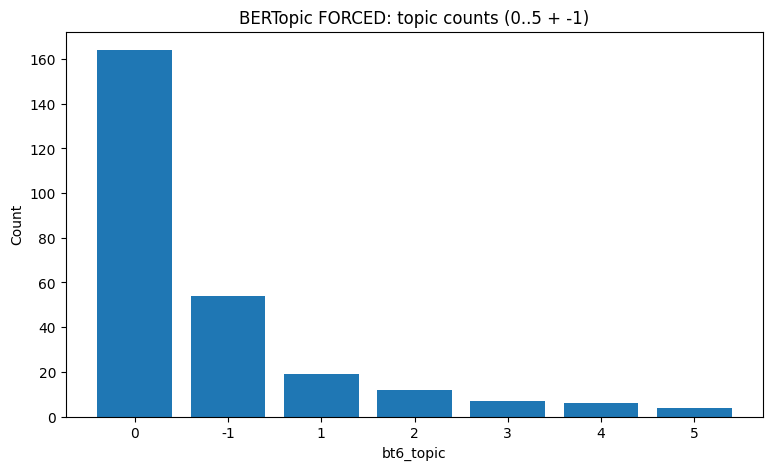

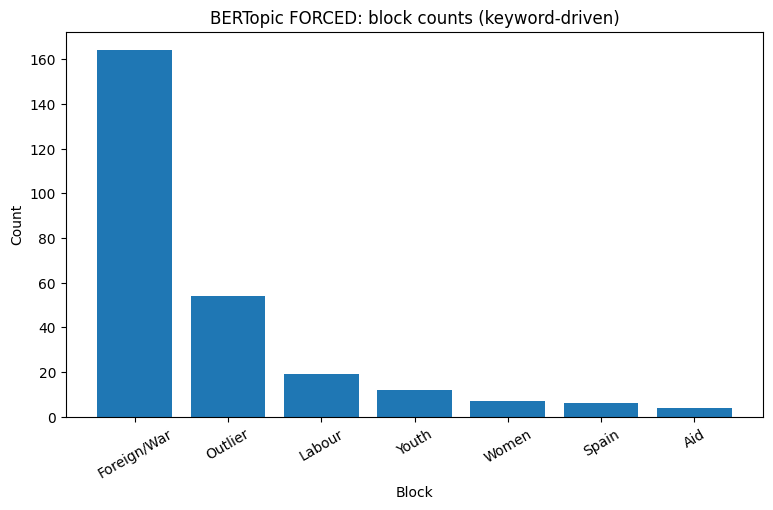

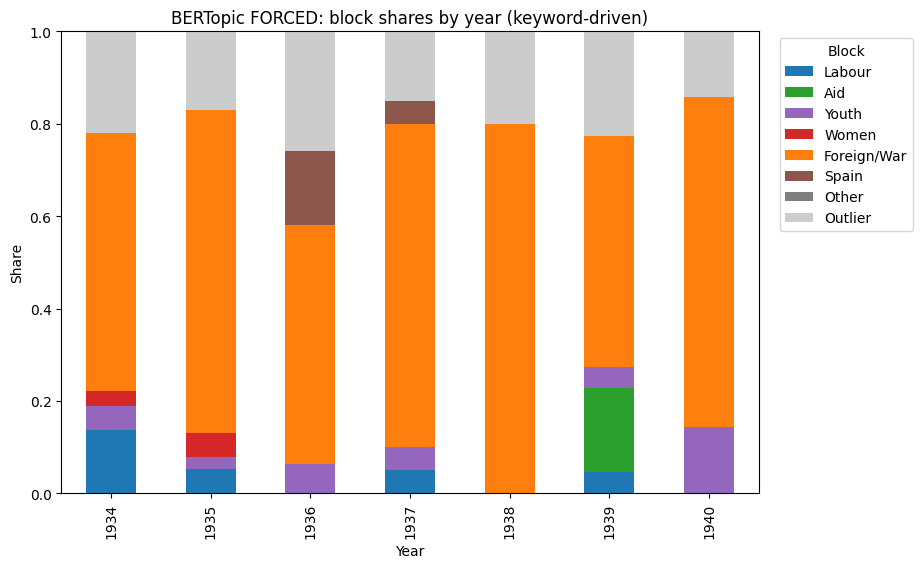

In [9]:
#@title BERTopic (FORCED): reduce to 6 topics + "STRICT-IF-POSSIBLE" 1-to-1 mapping with keyword-count scoring (bt6_*)
import os, random
import numpy as np
import pandas as pd

from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from hdbscan import HDBSCAN
from umap import UMAP
from scipy.optimize import linear_sum_assignment  # Hungarian

# ----------------
# 0) seeds
# ----------------
os.environ["PYTHONHASHSEED"] = "42"
random.seed(42)
np.random.seed(42)

texts_ber = df["clean"].tolist()

vectorizer_ber = CountVectorizer(
    ngram_range=(1,2),
    min_df=3,
    max_df=0.95,
    stop_words=list(STOPWORDS)
)

umap_model = UMAP(
    n_neighbors=30,
    min_dist=0.20,
    n_components=2,
    metric="cosine",
    random_state=42
)

hdbscan_model = HDBSCAN(
    min_cluster_size=3,
    min_samples=1,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True
)

# ----------------
# 1) BERTopic forced reduction
# ----------------
topic_model_6 = BERTopic(
    language="multilingual",
    vectorizer_model=vectorizer_ber,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    nr_topics=7,
    calculate_probabilities=True
)

bt6_topics, bt6_probs = topic_model_6.fit_transform(texts_ber)

df["bt6_topic"] = bt6_topics
df["bt6_topic_score"] = np.nan
if bt6_probs is not None:
    df["bt6_topic_score"] = bt6_probs.max(axis=1)

# ----------------
# 2) print topics
# ----------------
TOPN = 15
topic_ids_6 = sorted(int(t) for t in pd.Series(df["bt6_topic"]).dropna().unique() if int(t) >= 0)

print("\n=== BERTopic FORCED (nr_topics=6): topics ===")
for tid in topic_ids_6:
    words = topic_model_6.get_topic(int(tid)) or []
    top_terms = [w for (w, _) in words[:TOPN]]
    n_docs = int((df["bt6_topic"] == tid).sum())
    print(f"\nTopic {tid} (n={n_docs}):")
    print(" ", ", ".join(top_terms))

# -------------------------
# 3) Mapping: keyword-hit scoring + Hungarian (1-to-1),
# -------------------------
BLOCKS = ["Labour","Aid","Youth","Women","Foreign/War","Spain"]
DEFAULT_BLOCK = "Other"

BLOCK_ANCHORS = {
    "Spain": "spānijas spānijā spāņu fronte republika franko internacionāl brigāde republik madrid barselon",
    "Women": "sievietes sieviešu māte mātes bērns bērni ģimene ģimenes mājsaimniecība",
    "Youth": "jaunatne jaunatnes jaunietis jaunatnei lkjs skolnieks skolnieku skola skolas skolā students studenti pionier",
    "Aid": "sarkanā palīdzība palīdzības protests protestēt cietums cietumos ieslodzītie politieslodzītie spīdzināšana politpārvalde bendes murina ventspils karceris kara tiesa nāves sods",
    "Labour": "strādnieki strādnieku algas algu streiks streikā arodbiedrība arodbiedrības bezdarbnieki īres darbs darba nespēja apdrošināšana maizi",
    "Foreign/War": "karš karu pretkara fašisms fašistiskā hitlerisms hitler vācu vācija imperiālisms miera psrs sprs abesīnija austrija kolektīvā drošība"
}

# КЛЮЧЕВОЕ: расширяем Aid/Foreign/Youth и УБИРАЕМ 'front' из Foreign/War (он ломает Spain)
RULE_KEYWORDS = {
    "Spain": [
        "spān", "frank", "republik", "internacion", "brigād", "madrid", "barselon", "front"
    ],
    "Women": [
        "siev", "māt", "bērn", "ģimen", "dzemd", "mājsaim", "meiten"
    ],
    "Aid": [
        "palīdz", "sarkan", "cietum", "ieslodz", "politieslodz", "spīdzin",
        "politpārval", "murina", "ventspil", "bendes", "kara ties", "nāves sod",
        "karcer", "protest", "spiegu", "slepkav"
    ],
    "Labour": [
        "strād", "alg", "streik", "arodbiedr", "bezdarb", "īr", "apdrošin",
        "darbin", "maiz", "darb", "fabrik", "kapitāl", "prasīb", "nodokl"
    ],
    "Youth": [
        "lkjs", "jaun", "skol", "skoln", "student", "pionier"
    ],
    "Foreign/War": [
        "kar", "pretkar", "faš", "hitler", "vāc", "vācu", "vācija", "imper",
        "miera", "psrs", "sprs", "abesīn", "austrij", "tautu", "savienīb"
    ]
}

def topic_as_weighted_text(tid, topn=80):
    pairs = topic_model_6.get_topic(int(tid)) or []
    pairs = pairs[:topn]
    tokens = []
    for term, w in pairs:
        rep = 1
        if w >= 0.02: rep = 2
        if w >= 0.05: rep = 3
        if w >= 0.10: rep = 4
        tokens.extend([term] * rep)
    return " ".join(tokens)

def keyword_hit_score(top_terms, block):
    kws = RULE_KEYWORDS[block]
    score = 0.0
    for rank, term in enumerate(top_terms):
        t = str(term)
        pos_w = 1.0 / (1.0 + 0.18 * rank)
        hits = 0
        for kw in kws:
            if kw in t:
                hits += 1
        if hits:
            score += hits * pos_w
    return score

# top words
top_words_by_topic = {}
topic_texts = []
for tid in topic_ids_6:
    top_words = [w for (w, _) in (topic_model_6.get_topic(int(tid)) or [])[:30]]
    top_words_by_topic[tid] = top_words
    topic_texts.append(topic_as_weighted_text(tid, topn=80))

# cosine component
docs = [BLOCK_ANCHORS[b] for b in BLOCKS] + topic_texts
vec = TfidfVectorizer(ngram_range=(1,2), min_df=1)
X_all = vec.fit_transform(docs)
X_anchors = X_all[:len(BLOCKS)]
X_topics = X_all[len(BLOCKS):]
S_cos = cosine_similarity(X_topics, X_anchors)

# keyword component
alpha = 0.90
S = S_cos.copy()

for i, tid in enumerate(topic_ids_6):
    top_terms = top_words_by_topic[tid]
    for j, blk in enumerate(BLOCKS):
        kh = keyword_hit_score(top_terms, blk)

        # diagnostic bumps
        bump = 0.0
        if blk in ("Spain","Women") and kh > 0:
            bump = 1.50
        elif blk == "Aid" and kh > 0:
            bump = 0.80

        S[i, j] = S[i, j] + alpha * kh + bump

aid_hits_total = 0.0
for tid in topic_ids_6:
    aid_hits_total += keyword_hit_score(top_words_by_topic[tid], "Aid")

blocks_for_assignment = BLOCKS.copy()
if aid_hits_total < 0.20:
    print("\nNOTE: Aid signals are ~absent in bt6 topics -> do NOT force Aid in 1-to-1 assignment.")
    blocks_for_assignment = [b for b in BLOCKS if b != "Aid"]

# Hungarian on (topics x selected blocks)
col_idx = [BLOCKS.index(b) for b in blocks_for_assignment]
S_sub = S[:, col_idx]

row_ind, col_ind = linear_sum_assignment(-S_sub)

bt6_to_block_auto = {}
used_blocks = set()
for r, c in zip(row_ind, col_ind):
    tid = int(topic_ids_6[r])
    blk = blocks_for_assignment[int(c)]
    bt6_to_block_auto[tid] = blk
    used_blocks.add(blk)

# Any leftover topics (shouldn't happen here) -> best remaining by score
for i, tid in enumerate(topic_ids_6):
    if tid in bt6_to_block_auto:
        continue
    # choose best block among unused; if none -> DEFAULT
    candidates = [b for b in BLOCKS if b not in used_blocks]
    if not candidates:
        bt6_to_block_auto[tid] = DEFAULT_BLOCK
        continue
    cand_idx = [BLOCKS.index(b) for b in candidates]
    best_c = int(np.argmax(S[i, cand_idx]))
    bt6_to_block_auto[tid] = candidates[best_c]
    used_blocks.add(candidates[best_c])

print("\n=== AUTO mapping (KEYWORD-DRIVEN, 1-to-1 when meaningful): bt6_topic -> block ===")
for tid in topic_ids_6:
    blk = bt6_to_block_auto.get(tid, DEFAULT_BLOCK)
    print(f"Topic {tid}: {blk} | top: {', '.join(top_words_by_topic[tid][:10])}")

def map_bt6_block(tid):
    tid = int(tid)
    if tid < 0:
        return "Outlier"
    return bt6_to_block_auto.get(tid, DEFAULT_BLOCK)

df["bt6_block"] = df["bt6_topic"].apply(map_bt6_block)

# ----------------
# 4) plots
# ----------------
plot_counts_bar(df["bt6_topic"], "BERTopic FORCED: topic counts (0..5 + -1)", xlabel="bt6_topic", rotate_xticks=0)
plot_counts_bar(df["bt6_block"], "BERTopic FORCED: block counts (keyword-driven)", xlabel="Block", rotate_xticks=30)
plot_shares_by_year(df, "bt6_block", "BERTopic FORCED: block shares by year (keyword-driven)")



=== BERTopic tuned (nr_topics=7) -> 6 non-outlier topics ===

Topic 0 (n=164):
  cīņas, darbaļaužu, tie, fašisma, fašistiskā, kur, biedri, cīņā, visu zemju, uzvaras

Topic 1 (n=19):
  bezdarbnieku, algas, biedri, lauku, cīņas, strādniekus, bezdarba, apdrošināšanu, zemnieku, darbos

Topic 2 (n=19):
  sievietes, darba sievietes, mātes, cīņas, sieviešu, maijā, sieviete, maijs, diena, bērnu

Topic 3 (n=6):
  spānijas, spāņu, spāņu tautas, spānijā, fašisma, tautas frontes, uzvara, cīnītāju, fašisms, spānijas tautas

Topic 4 (n=4):
  latvju, līgumu, savstarpējās, latvju tautai, neatkarību, latvju tautas, vāciešiem, patstāvību, palīdzības, valstu

=== AUTO mapping (KEYWORD-DRIVEN, 1-to-1 when meaningful): bt6_topic -> block ===
Topic 0: Foreign/War | top: cīņas, darbaļaužu, tie, fašisma, fašistiskā, kur, biedri, cīņā, visu zemju, uzvaras
Topic 1: Labour | top: bezdarbnieku, algas, biedri, lauku, cīņas, strādniekus, bezdarba, apdrošināšanu, zemnieku, darbos
Topic 2: Women | top: sievietes, da

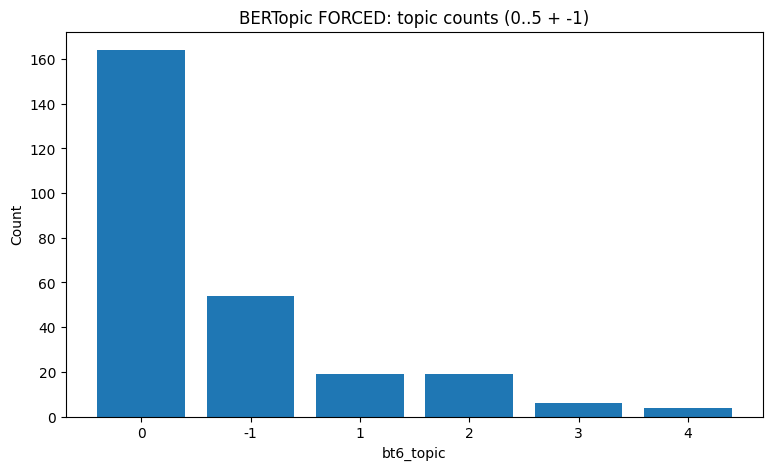

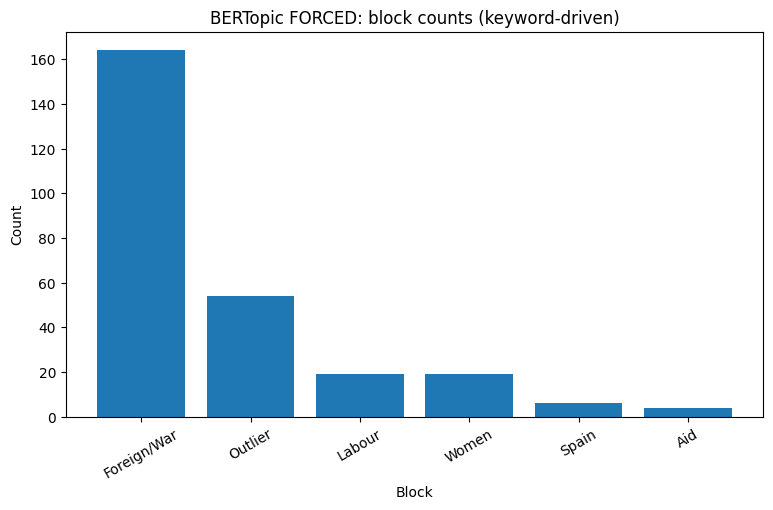

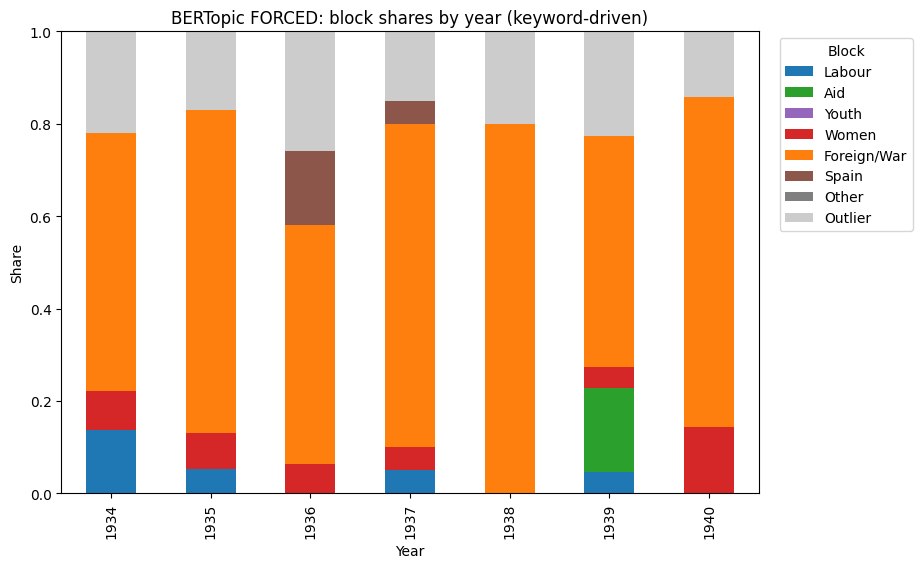

In [10]:
#@title BERTopic (FORCED): reduce to 6 topics + "STRICT-IF-POSSIBLE" 1-to-1 mapping with keyword-count scoring (bt6_*)
import os, random
import numpy as np
import pandas as pd

from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from hdbscan import HDBSCAN
from umap import UMAP
from scipy.optimize import linear_sum_assignment  # Hungarian

# ----------------
# 0) seeds
# ----------------
os.environ["PYTHONHASHSEED"] = "42"
random.seed(42)
np.random.seed(42)

texts_ber = df["clean"].tolist()

vectorizer_ber = CountVectorizer(
    ngram_range=(1,2),
    min_df=3,
    max_df=0.95,
    stop_words=list(STOPWORDS)
)

umap_model = UMAP(
    n_neighbors=30,
    min_dist=0.20,
    n_components=2,
    metric="cosine",
    random_state=42
)

hdbscan_model = HDBSCAN(
    min_cluster_size=3,
    min_samples=1,
    metric="euclidean",
    cluster_selection_method="eom",
    prediction_data=True
)

# ----------------
# 1) BERTopic forced reduction
# ----------------
topic_model_6 = BERTopic(
    language="multilingual",
    vectorizer_model=vectorizer_ber,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    nr_topics=6,
    calculate_probabilities=True
)

bt6_topics, bt6_probs = topic_model_6.fit_transform(texts_ber)

df["bt6_topic"] = bt6_topics
df["bt6_topic_score"] = np.nan
if bt6_probs is not None:
    df["bt6_topic_score"] = bt6_probs.max(axis=1)

# ----------------
# 2) print topics
# ----------------
TOPN = 15
topic_ids_6 = sorted(int(t) for t in pd.Series(df["bt6_topic"]).dropna().unique() if int(t) >= 0)

print("\n=== BERTopic tuned (nr_topics=7) -> 6 non-outlier topics ===")
for tid in topic_ids_6:
    words = topic_model_6.get_topic(int(tid)) or []
    top_terms = [w for (w, _) in words[:TOPN]]
    n_docs = int((df["bt6_topic"] == tid).sum())
    print(f"\nTopic {tid} (n={n_docs}):")
    print(" ", ", ".join(top_terms))

# -------------------------
# 3) Mapping: keyword-hit scoring + Hungarian (1-to-1),
# -------------------------
BLOCKS = ["Labour","Aid","Youth","Women","Foreign/War","Spain"]
DEFAULT_BLOCK = "Other"

BLOCK_ANCHORS = {
    "Spain": "spānijas spānijā spāņu fronte republika franko internacionāl brigāde republik madrid barselon",
    "Women": "sievietes sieviešu māte mātes bērns bērni ģimene ģimenes mājsaimniecība",
    "Youth": "jaunatne jaunatnes jaunietis jaunatnei lkjs skolnieks skolnieku skola skolas skolā students studenti pionier",
    "Aid": "sarkanā palīdzība palīdzības protests protestēt cietums cietumos ieslodzītie politieslodzītie spīdzināšana politpārvalde bendes murina ventspils karceris kara tiesa nāves sods",
    "Labour": "strādnieki strādnieku algas algu streiks streikā arodbiedrība arodbiedrības bezdarbnieki īres darbs darba nespēja apdrošināšana maizi",
    "Foreign/War": "karš karu pretkara fašisms fašistiskā hitlerisms hitler vācu vācija imperiālisms miera psrs sprs abesīnija austrija kolektīvā drošība"
}

RULE_KEYWORDS = {
    "Spain": [
        "spān", "frank", "republik", "internacion", "brigād", "madrid", "barselon", "front"
    ],
    "Women": [
        "siev", "māt", "bērn", "ģimen", "dzemd", "mājsaim", "meiten"
    ],
    "Aid": [
        "palīdz", "sarkan", "cietum", "ieslodz", "politieslodz", "spīdzin",
        "politpārval", "murina", "ventspil", "bendes", "kara ties", "nāves sod",
        "karcer", "protest", "spiegu", "slepkav"
    ],
    "Labour": [
        "strād", "alg", "streik", "arodbiedr", "bezdarb", "īr", "apdrošin",
        "darbin", "maiz", "darb", "fabrik", "kapitāl", "prasīb", "nodokl"
    ],
    "Youth": [
        "lkjs", "jaun", "skol", "skoln", "student", "pionier"
    ],
    "Foreign/War": [
        "kar", "pretkar", "faš", "hitler", "vāc", "vācu", "vācija", "imper",
        "miera", "psrs", "sprs", "abesīn", "austrij", "tautu", "savienīb"
    ]
}

def topic_as_weighted_text(tid, topn=80):
    pairs = topic_model_6.get_topic(int(tid)) or []
    pairs = pairs[:topn]
    tokens = []
    for term, w in pairs:
        rep = 1
        if w >= 0.02: rep = 2
        if w >= 0.05: rep = 3
        if w >= 0.10: rep = 4
        tokens.extend([term] * rep)
    return " ".join(tokens)

def keyword_hit_score(top_terms, block):

    kws = RULE_KEYWORDS[block]
    score = 0.0
    for rank, term in enumerate(top_terms):
        t = str(term)
        pos_w = 1.0 / (1.0 + 0.18 * rank)  # чуть сильнее штраф за поздние
        hits = 0
        for kw in kws:
            if kw in t:
                hits += 1
        if hits:
            score += hits * pos_w
    return score

# top words
top_words_by_topic = {}
topic_texts = []
for tid in topic_ids_6:
    top_words = [w for (w, _) in (topic_model_6.get_topic(int(tid)) or [])[:30]]
    top_words_by_topic[tid] = top_words
    topic_texts.append(topic_as_weighted_text(tid, topn=80))

# cosine component
docs = [BLOCK_ANCHORS[b] for b in BLOCKS] + topic_texts
vec = TfidfVectorizer(ngram_range=(1,2), min_df=1)
X_all = vec.fit_transform(docs)
X_anchors = X_all[:len(BLOCKS)]
X_topics = X_all[len(BLOCKS):]
S_cos = cosine_similarity(X_topics, X_anchors)

# keyword component
alpha = 0.90
S = S_cos.copy()

for i, tid in enumerate(topic_ids_6):
    top_terms = top_words_by_topic[tid]
    for j, blk in enumerate(BLOCKS):
        kh = keyword_hit_score(top_terms, blk)

        # diagnostic bumps
        bump = 0.0
        if blk in ("Spain","Women") and kh > 0:
            bump = 1.50
        elif blk == "Aid" and kh > 0:
            bump = 0.80

        S[i, j] = S[i, j] + alpha * kh + bump

blocks_for_assignment = BLOCKS.copy()


# Hungarian on (topics x selected blocks)
col_idx = [BLOCKS.index(b) for b in blocks_for_assignment]
S_sub = S[:, col_idx]

row_ind, col_ind = linear_sum_assignment(-S_sub)

bt6_to_block_auto = {}
used_blocks = set()
for r, c in zip(row_ind, col_ind):
    tid = int(topic_ids_6[r])
    blk = blocks_for_assignment[int(c)]
    bt6_to_block_auto[tid] = blk
    used_blocks.add(blk)

# Any leftover topics (shouldn't happen here) -> best remaining by score
for i, tid in enumerate(topic_ids_6):
    if tid in bt6_to_block_auto:
        continue
    # choose best block among unused; if none -> DEFAULT
    candidates = [b for b in BLOCKS if b not in used_blocks]
    if not candidates:
        bt6_to_block_auto[tid] = DEFAULT_BLOCK
        continue
    cand_idx = [BLOCKS.index(b) for b in candidates]
    best_c = int(np.argmax(S[i, cand_idx]))
    bt6_to_block_auto[tid] = candidates[best_c]
    used_blocks.add(candidates[best_c])

print("\n=== AUTO mapping (KEYWORD-DRIVEN, 1-to-1 when meaningful): bt6_topic -> block ===")
for tid in topic_ids_6:
    blk = bt6_to_block_auto.get(tid, DEFAULT_BLOCK)
    print(f"Topic {tid}: {blk} | top: {', '.join(top_words_by_topic[tid][:10])}")

def map_bt6_block(tid):
    tid = int(tid)
    if tid < 0:
        return "Outlier"
    return bt6_to_block_auto.get(tid, DEFAULT_BLOCK)

df["bt6_block"] = df["bt6_topic"].apply(map_bt6_block)

# ----------------
# 4) plots
# ----------------
plot_counts_bar(df["bt6_topic"], "BERTopic FORCED: topic counts (0..5 + -1)", xlabel="bt6_topic", rotate_xticks=0)
plot_counts_bar(df["bt6_block"], "BERTopic FORCED: block counts (keyword-driven)", xlabel="Block", rotate_xticks=30)
plot_shares_by_year(df, "bt6_block", "BERTopic FORCED: block shares by year (keyword-driven)")



=== NMF topics (top words) ===

Topic 0 (n=76):
  strādnieku, darba, algas, strādniekiem, strādnieki, biedri, arodbiedrību, strādniekus, arodbiedrības, algu, valdība, mūsu, bezdarbnieku, cīņas, mums

Topic 1 (n=44):
  tautas, latvijas, spānijas, tautu, brīvības, latvju, tautai, ulmaņa, vācu, sprs, spāņu, tauta, brīvību, fašistu, baltijas

Topic 2 (n=62):
  sprs, padomju, kara, latvijas, karu, darbaļaužu, pasaules, karš, visu, proletariāta, revolūcijas, dzīvo, vācijas, darbaļaudis, oktobra

Topic 3 (n=7):
  sievietes, darba sievietes, mātes, sieviešu, darba, sievietes mātes, bērnu, daudz, sievietēm, ģimenes, sieviete, buržuju, vienādu, biedru vīrieti, vīrieti

Topic 4 (n=38):
  jaunatnes, darba, jaunatne, jaunatnei, skolu, jaunatni, latvijas, darba jaunatnes, strādnieku, skolas, skolnieku, darba jaunatne, jaunieši, cīņas, laukos

Topic 5 (n=39):
  latvijas, palīdzības, sarkanās palīdzības, darba, sarkanās, fašistu, cietumos, nāves, darba tautas, politieslodzītajiem, protesta, ziemas, t

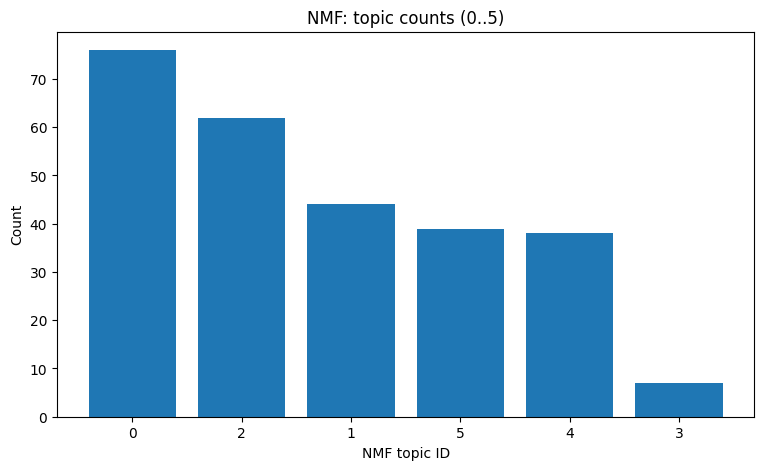

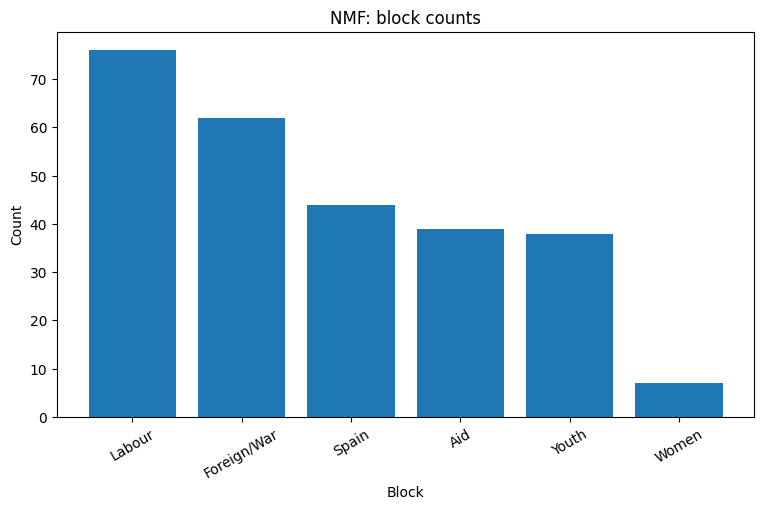

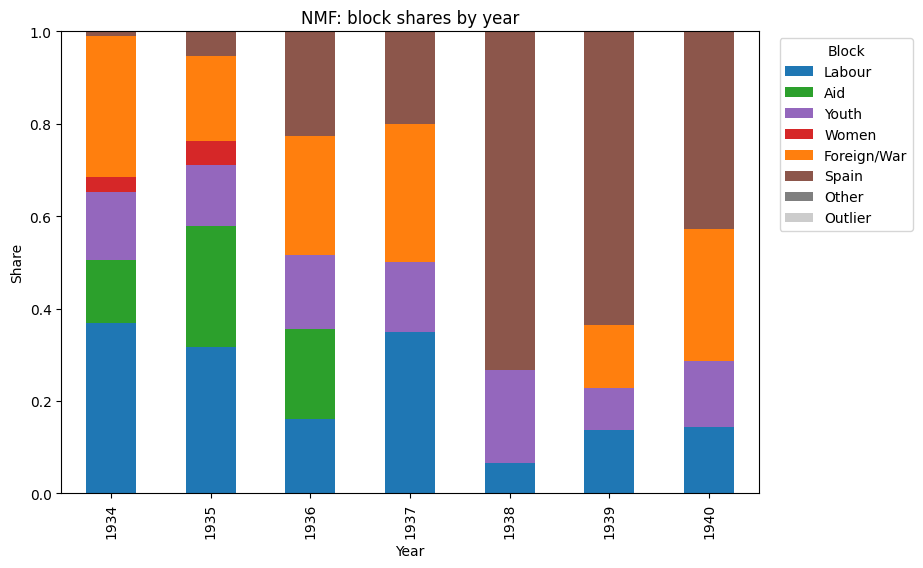

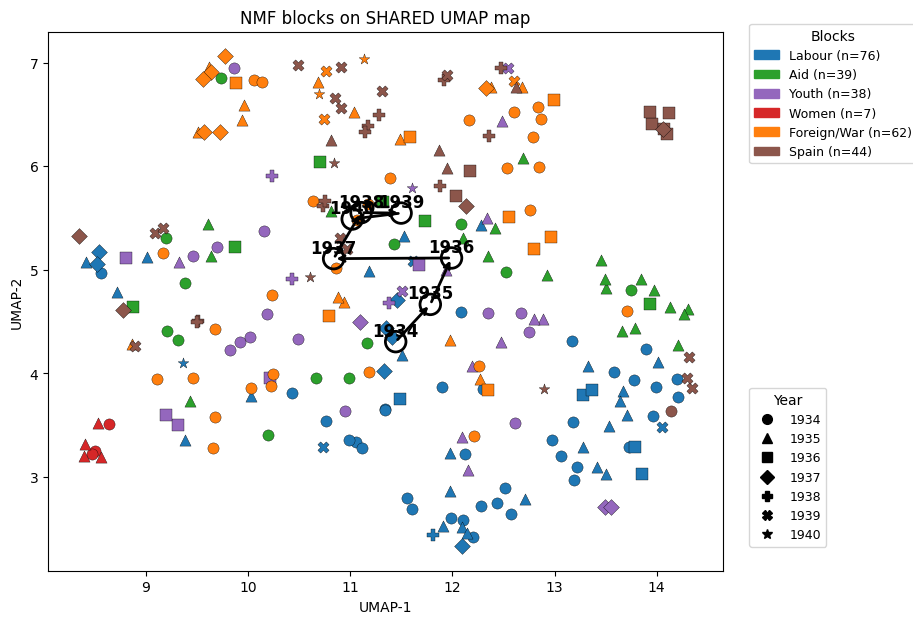

In [11]:
#@title 7) TF–IDF -> NMF + AUTO 6-block mapping + plots (creates H, W, nmf_topic, nmf_block)
import numpy as np
import pandas as pd
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# --- sanity: need TF-IDF matrix ---
if "X" not in globals() or "feature_names" not in globals():
    raise NameError("Missing X/feature_names. Run the TF–IDF vectorization cell first.")

# ---------------------------
# 1) NMF fit
# ---------------------------
N_TOPICS = 6
nmf = NMF(
    n_components=N_TOPICS,
    random_state=42,
    init="nndsvda",
    max_iter=600
)
W = nmf.fit_transform(X)     # doc-topic
H = nmf.components_          # topic-term

df["nmf_topic"] = W.argmax(axis=1)
df["nmf_topic_score"] = W.max(axis=1)

# ---------------------------
# 2) Print NMF topics (top words) + save nmf_topics_words
# ---------------------------
TOPN = 15
nmf_topics_words = {}
print("\n=== NMF topics (top words) ===")
for k in range(N_TOPICS):
    row = H[k]
    top_idx = np.argsort(row)[::-1][:TOPN]
    top_terms = [feature_names[i] for i in top_idx]
    nmf_topics_words[k] = top_terms
    n_docs = int((df["nmf_topic"] == k).sum())
    print(f"\nTopic {k} (n={n_docs}):")
    print(" ", ", ".join(top_terms))

# ---------------------------
# 3) AUTO aggregation to 6 blocks (anchors + cosine, как у BERTopic)
# ---------------------------
BLOCKS = ["Labour","Aid","Youth","Women","Foreign/War","Spain"]
DEFAULT_BLOCK = "Other"

BLOCK_ANCHORS = {
    "Spain": "spānijas spānijā spāņu fronte republika franko internacionāl brigāde",
    "Women": "sievietes sieviešu mātes bērnu bērni ģimenes mājsaimniecība",
    "Youth": "jaunatne jaunatnes jaunatnei jaunietis lkjs skolnieku skolu skolas skolā student pionier",
    "Aid": "cietumos ieslodzītie politieslodzītajiem spīdzināšana spīdzin bendes protests politpārvalde murina ventspils",
    "Labour": "strādnieku strādniekiem algas algu streikā arodbiedrību bezdarbnieku īres ierēdņi pašvaldību darbinieku",
    "Foreign/War": "karš karu pretkara fašisms fašistiskā pretfašistu hitler vācu vācija imperiālisms miera psrs sprs oktobra revolūcija abesīnija"
}

def override_block_from_words(words_joined: str):
    if "spān" in words_joined:
        return "Spain", "OVERRIDE"
    if any(x in words_joined for x in ["siev", "māt", "bērn", "ģimen"]):
        return "Women", "OVERRIDE"
    return None, None

def nmf_topic_as_weighted_text(topic_id: int, topn=40):
    row = H[topic_id]
    top_idx = np.argsort(row)[::-1][:topn]
    top_weights = row[top_idx]
    p60 = np.percentile(top_weights, 60)
    p80 = np.percentile(top_weights, 80)
    p95 = np.percentile(top_weights, 95)

    tokens = []
    for j in top_idx:
        term = feature_names[j]
        w = row[j]
        rep = 1
        if w >= p95: rep = 4
        elif w >= p80: rep = 3
        elif w >= p60: rep = 2
        tokens.extend([term] * rep)
    return " ".join(tokens)

topic_ids = list(range(N_TOPICS))
docs = [BLOCK_ANCHORS[b] for b in BLOCKS] + [nmf_topic_as_weighted_text(t, topn=40) for t in topic_ids]

vec = TfidfVectorizer(analyzer="char_wb", ngram_range=(3,5), min_df=1)
X_all = vec.fit_transform(docs)
X_anchors = X_all[:len(BLOCKS)]
X_topics = X_all[len(BLOCKS):]

nmf_to_block_auto = {}
print("\n=== AUTO NMF topic -> block mapping (anchor cosine similarity) ===")

for i, tid in enumerate(topic_ids):
    top_words = nmf_topics_words.get(tid, [])
    joined = " ".join(top_words)
    sims = cosine_similarity(X_topics[i], X_anchors)[0]

    oblk, rule = override_block_from_words(joined)
    if oblk is not None:
        nmf_to_block_auto[tid] = oblk
        print(f"\nTopic {tid}: {oblk}  [{rule}]")
        print("  top words:", ", ".join(top_words[:12]))
        continue

    sims = cosine_similarity(X_topics[i], X_anchors)[0]
    best_idx = int(np.argmax(sims))
    best_blk = BLOCKS[best_idx]
    nmf_to_block_auto[tid] = best_blk

    sim_sorted = dict(sorted(
        {BLOCKS[j]: float(sims[j]) for j in range(len(BLOCKS))}.items(),
        key=lambda x: x[1], reverse=True
    ))
    print(f"\nTopic {tid}: {best_blk}  [COSINE]")
    print("  sims:", sim_sorted)
    print("  top words:", ", ".join(top_words[:12]))

df["nmf_block"] = df["nmf_topic"].apply(lambda t: nmf_to_block_auto.get(int(t), DEFAULT_BLOCK))

# ---------------------------
# 4) plots
# ---------------------------
plot_counts_bar(df["nmf_topic"], "NMF: topic counts (0..5)", xlabel="NMF topic ID", rotate_xticks=0)
plot_counts_bar(df["nmf_block"], "NMF: block counts", xlabel="Block", rotate_xticks=30)
plot_shares_by_year(df, "nmf_block", "NMF: block shares by year")
plot_shared_umap_with_year_centroids(df, "nmf_block", "NMF blocks on SHARED UMAP map")

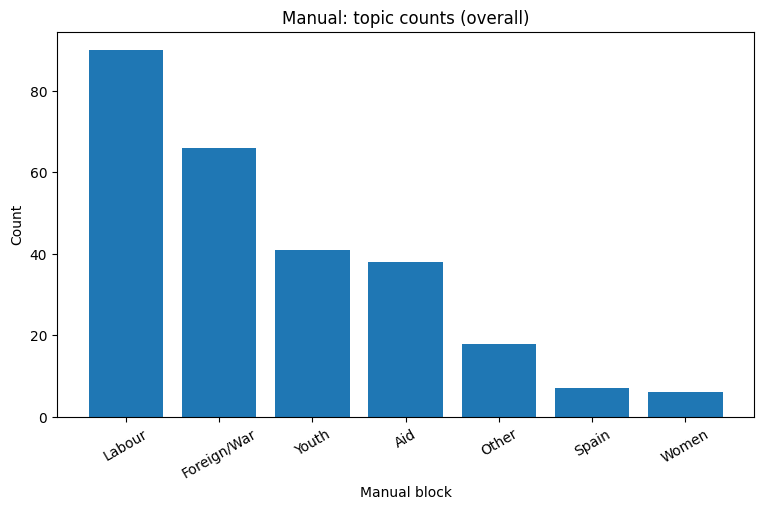

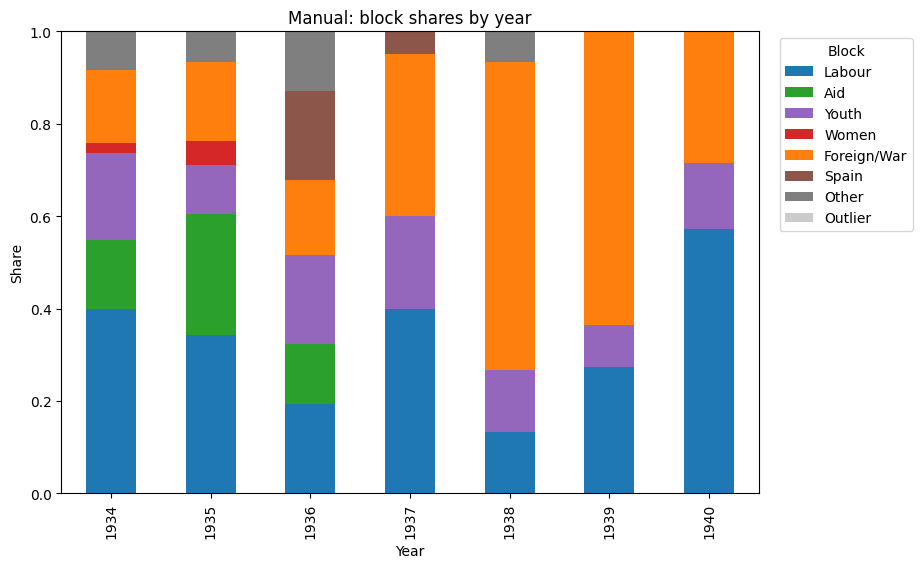

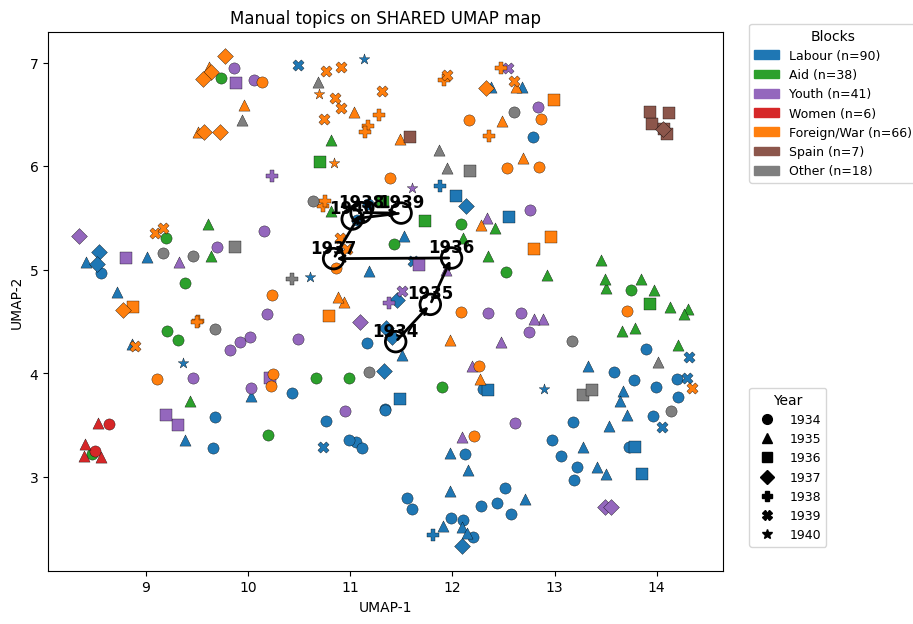

In [12]:
#@title 9) Manual histogram by year + shared UMAP
# (9) histogram (shares by year) for manual labels; years come from ZIP
plot_counts_bar(df["manual_block"], "Manual: topic counts (overall)", xlabel="Manual block", rotate_xticks=30)
plot_shares_by_year(df, "manual_block", "Manual: block shares by year")
plot_shared_umap_with_year_centroids(df, "manual_block", "Manual topics on SHARED UMAP map")

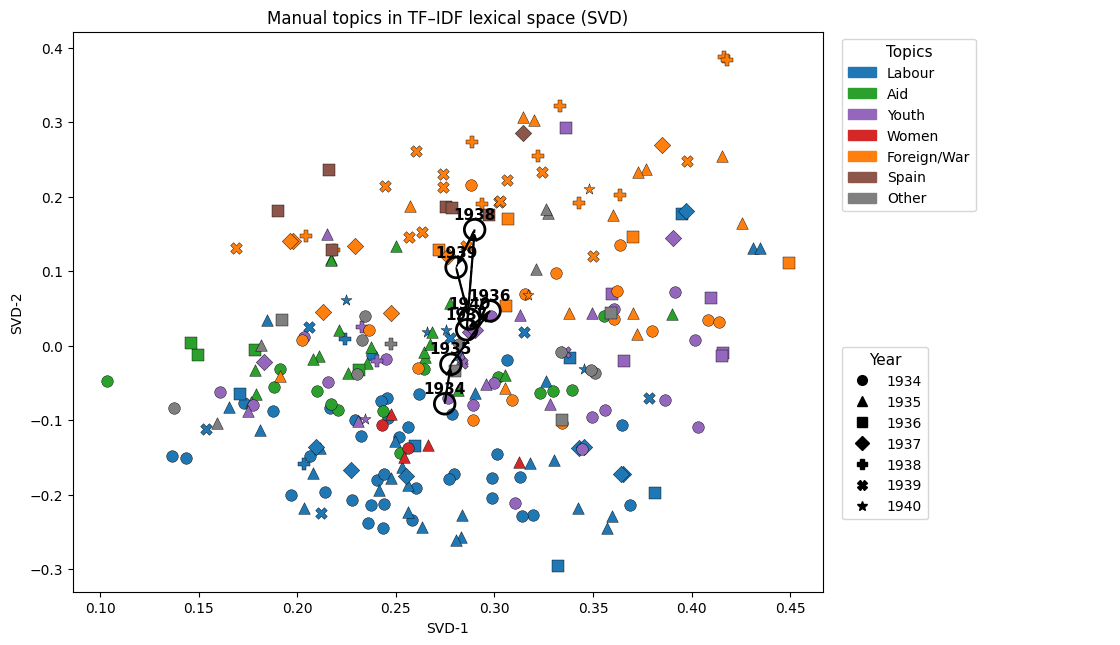

In [13]:
#@title EXTRA (Supplementary): TF–IDF lexical space via SVD (OLD MAP) + legends on a separate right panel
# This version NEVER gets clipped because legends live in a dedicated side-axes.

from sklearn.decomposition import TruncatedSVD
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D

# --- 1) SVD on TF–IDF ---
svd = TruncatedSVD(n_components=2, random_state=42)
coords_svd = svd.fit_transform(X)

# --- 2) jitter ---
rng = np.random.default_rng(42)
jitter = 0.002
x = coords_svd[:, 0] + rng.normal(0, jitter, len(coords_svd))
y = coords_svd[:, 1] + rng.normal(0, jitter, len(coords_svd))

# --- 3) palettes / order ---
YEAR_MARKERS = {
    1934: 'o', 1935: '^', 1936: 's', 1937: 'D', 1938: 'P', 1939: 'X', 1940: '*',
    None: 'x'
}

BLOCK_PALETTE = {
    "Labour":      "#1f77b4",
    "Aid":         "#2ca02c",
    "Youth":       "#9467bd",
    "Women":       "#d62728",
    "Foreign/War": "#ff7f0e",
    "Spain":       "#8c564b",
    "Other":       "#7f7f7f",
    "Outlier":     "#cccccc",
}

BLOCK_ORDER = ["Labour","Aid","Youth","Women","Foreign/War","Spain","Other","Outlier"]

# --- 4) labels/years ---
label_col = "manual_block" if "manual_block" in df.columns else "manual_topic"
labels = df[label_col].fillna("Outlier")
years = df["year"]

# --- 5) figure with a dedicated legend panel on the right ---
fig = plt.figure(figsize=(12.5, 7))
ax = fig.add_axes([0.07, 0.10, 0.60, 0.80])      # main plot
side_ax = fig.add_axes([0.68, 0.10, 0.22, 0.80]) # legend panel
side_ax.axis("off")

# --- 6) scatter ---
for blk in BLOCK_ORDER:
    if blk not in BLOCK_PALETTE:
        continue
    mask_blk = (labels == blk).values
    if not mask_blk.any():
        continue

    for yr, marker in YEAR_MARKERS.items():
        mask = mask_blk & (years == yr)
        if not mask.any():
            continue
        ax.scatter(
            x[mask], y[mask],
            c=BLOCK_PALETTE[blk], s=70, marker=marker,
            edgecolors="k", linewidths=0.3
        )

# --- 7) year centroids + arrows (only years present) ---
present_years = set(pd.to_numeric(years, errors="coerce").dropna().astype(int).unique())
years_to_use = [yr for yr in range(1934, 1941) if yr in present_years]

centers = {}
for yr in years_to_use:
    m = (years == yr).values
    if m.sum() == 0:
        continue
    cx, cy = float(np.mean(x[m])), float(np.mean(y[m]))
    centers[int(yr)] = (cx, cy)
    ax.scatter([cx], [cy], s=220, facecolors="none", edgecolors="k", linewidths=2.0, zorder=10)
    ax.text(cx, cy + 0.01, str(int(yr)), ha="center", va="bottom", fontsize=11, weight="bold", zorder=11)

if len(years_to_use) >= 2:
    for i in range(len(years_to_use) - 1):
        y1, y2 = years_to_use[i], years_to_use[i + 1]
        if y1 in centers and y2 in centers:
            (x1, y1c), (x2, y2c) = centers[y1], centers[y2]
            ax.plot([x1, x2], [y1c, y2c], linestyle="--", color="k", linewidth=1.2, zorder=9)
            ax.annotate(
                "", xy=(x2, y2c), xytext=(x1, y1c),
                arrowprops=dict(arrowstyle="->", color="k", lw=1.6),
                zorder=9
            )

# --- 8) labels ---
ax.set_title("Manual topics in TF–IDF lexical space (SVD)")
ax.set_xlabel("SVD-1")
ax.set_ylabel("SVD-2")

# --- 9) legends in side panel (guaranteed space) ---
counts = labels.value_counts()

topic_handles = []
for blk in BLOCK_ORDER:
    if int(counts.get(blk, 0)) == 0:
        continue
    topic_handles.append(mpatches.Patch(color=BLOCK_PALETTE.get(blk, "#7f7f7f"), label=blk))

year_handles = []
for yr, marker in YEAR_MARKERS.items():
    if yr is None:
        if years.isna().any():
            year_handles.append(Line2D([0],[0], marker=marker, linestyle="None", color="k",
                                       label="Unknown", markersize=7))
    else:
        if (years == yr).any():
            year_handles.append(Line2D([0],[0], marker=marker, linestyle="None", color="k",
                                       label=str(int(yr)), markersize=7))

leg1 = side_ax.legend(handles=topic_handles, title="Topics",
                      loc="upper left", bbox_to_anchor=(0.0, 1.0),
                      frameon=True, fontsize=10, title_fontsize=11)
side_ax.add_artist(leg1)

_ = side_ax.legend(handles=year_handles, title="Year",
                   loc="upper left", bbox_to_anchor=(0.0, 0.45),
                   frameon=True, fontsize=10, title_fontsize=11)

plt.show()


In [14]:
#@title 10) Compare NMF vs Manual (robust: auto-create nmf_block if missing)
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# --- sanity: manual must exist ---
if "manual_topic" not in df.columns:
    raise KeyError("df['manual_topic'] is missing. You need manual labels to evaluate accuracy.")

# --- if nmf_block missing, try to build it ---
if "nmf_block" not in df.columns:

    # Case A: you already have nmf_topic + mapping dict from previous cell
    mapping = None
    for name in ["nmf_to_block_auto", "nmf_to_block", "nmf_topic_to_block"]:
        if name in globals() and isinstance(globals()[name], dict) and len(globals()[name]) > 0:
            mapping = globals()[name]
            break

    if mapping is not None and "nmf_topic" in df.columns:
        df["nmf_block"] = df["nmf_topic"].apply(lambda t: mapping.get(int(t), "Other") if pd.notna(t) else np.nan)

    else:
        # Case B: build nmf_block via anchor cosine similarity using NMF topic top terms
        # Need: nmf_topic column + a way to get top words for each nmf topic.
        if "nmf_topic" not in df.columns:
            raise KeyError(
                "df['nmf_block'] is missing AND df['nmf_topic'] is missing. "
                "Run the NMF modeling cell first (the one that creates df['nmf_topic'])."
            )

        # Try to find topic->top_terms somewhere (common patterns)
        # Accept: nmf_topics_words (dict), nmf_top_words (dict), nmf_model + tfidf_vectorizer, etc.
        topic2words = None
        for name in ["nmf_topic_words", "nmf_topics_words", "nmf_top_words", "nmf_topic_top_terms"]:
            if name in globals() and isinstance(globals()[name], dict) and len(globals()[name]) > 0:
                topic2words = globals()[name]
                break

        if topic2words is None:
            raise KeyError(
                "df['nmf_block'] is missing. I also couldn't find a dict like "
                "nmf_topics_words/nmf_top_words with top terms per NMF topic. "
                "Export top words per topic in your NMF cell (topic_id -> list of terms), "
                "or keep nmf_to_block_auto dict from that cell."
            )

        BLOCKS = ["Labour","Aid","Youth","Women","Foreign/War","Spain"]
        DEFAULT_BLOCK = "Other"

        BLOCK_ANCHORS = {
            "Spain": "spānijas spānijā spāņu fronte republika franko internacionāl brigāde",
            "Women": "sievietes sieviešu mātes bērnu bērni ģimenes mājsaimniecība",
            "Youth": "lkjs skolnieku skolu skolas skolā student pionier jaunatne jaunietis",
            "Aid": "cietumos ieslodzītie politieslodzītajiem spīdzināšana spīdzin bendes protests politpārvalde murina ventspils",
            "Labour": "strādnieku strādniekiem algas algu streikā arodbiedrību bezdarbnieku darba nespējas īres ierēdņi pašvaldību darbinieku",
            "Foreign/War": "karš karu pretkara fašisms fašistiskā pretfašistu hitler vācu vācija imperiālisms miera psrs sprs oktobra revolūcija abesīnija"
        }

        def override(words_joined: str):
            if "spān" in words_joined:
                return "Spain"
            if any(x in words_joined for x in ["siev", "māt", "bērn", "ģimen"]):
                return "Women"
            return None

        # Build TF-IDF char ngrams on anchors + topics (as text)
        topic_ids = sorted(int(t) for t in pd.Series(df["nmf_topic"]).dropna().unique())
        docs = [BLOCK_ANCHORS[b] for b in BLOCKS]
        for tid in topic_ids:
            words = topic2words.get(tid, [])
            if isinstance(words, str):
                words = words.split()
            docs.append(" ".join(words[:30]))

        vec = TfidfVectorizer(analyzer="char_wb", ngram_range=(3,5), min_df=1)
        X = vec.fit_transform(docs)
        X_anchors = X[:len(BLOCKS)]
        X_topics = X[len(BLOCKS):]

        nmf_map = {}
        for i, tid in enumerate(topic_ids):
            words = topic2words.get(tid, [])
            if isinstance(words, str):
                words = words.split()
            joined = " ".join(words[:30])

            ob = override(joined)
            if ob is not None:
                nmf_map[tid] = ob
                continue

            sims = cosine_similarity(X_topics[i], X_anchors)[0]
            nmf_map[tid] = BLOCKS[int(np.argmax(sims))]

        df["nmf_block"] = df["nmf_topic"].apply(lambda t: nmf_map.get(int(t), DEFAULT_BLOCK) if pd.notna(t) else np.nan)

# --- now evaluation (works if nmf_block exists) ---
eval_mask = df["manual_topic"].notna() & df["nmf_block"].notna()

nmf_acc = (df.loc[eval_mask, "nmf_block"] == df.loc[eval_mask, "manual_topic"]).mean()

print("NMF vs manual accuracy (exact match):", round(float(nmf_acc), 3))
print("Evaluated docs:", int(eval_mask.sum()), "/", len(df))

display(pd.crosstab(
    df.loc[eval_mask, "manual_topic"],
    df.loc[eval_mask, "nmf_block"],
    rownames=["manual"],
    colnames=["NMF"]
))


NMF vs manual accuracy (exact match): 0.703
Evaluated docs: 266 / 266


NMF,Aid,Foreign/War,Labour,Spain,Women,Youth
manual,,,,,,
Aid,35,0,1,1,1,0
Foreign/War,2,37,2,24,0,1
Labour,1,11,69,8,0,1
Other,1,7,4,4,0,2
Spain,0,1,0,6,0,0
Women,0,0,0,0,6,0
Youth,0,6,0,1,0,34


In [15]:
#@title 11) Compare BERTopic vs Manual (accuracy + crosstab)
# --- VERSION 1 (manual): exclude Outlier ---
tmp = df.copy()
mask1 = tmp["manual_topic"].notna() & tmp["bt_block"].notna()
mask1 = mask1 & (tmp["bt_block"] != "Outlier") & (tmp["manual_topic"] != "Outlier")

bt_acc1 = (tmp.loc[mask1, "bt_block"] == tmp.loc[mask1, "manual_topic"]).mean()
print("BERTopic vs manual accuracy (exclude Outlier):", round(float(bt_acc1), 3))
print("Evaluated docs:", int(mask1.sum()), "/", len(tmp))
display(pd.crosstab(
    tmp.loc[mask1, "manual_topic"],
    tmp.loc[mask1, "bt_block"],
    rownames=["manual"],
    colnames=["BERTopic"]
))

# --- VERSION 2 (manual): merge Outlier -> Other ---
tmp2 = df.copy()
tmp2["bt_block_m"] = tmp2["bt_block"].fillna("Other").replace({"Outlier": "Other"})
tmp2["manual_m"] = tmp2["manual_topic"].fillna("Other").replace({"Outlier": "Other"})

mask2 = tmp2["manual_m"].notna() & tmp2["bt_block_m"].notna()

bt_acc2 = (tmp2.loc[mask2, "bt_block_m"] == tmp2.loc[mask2, "manual_m"]).mean()
print("BERTopic vs manual accuracy (Outlier→Other):", round(float(bt_acc2), 3))
print("Evaluated docs:", int(mask2.sum()), "/", len(tmp2))
display(pd.crosstab(
    tmp2.loc[mask2, "manual_m"],
    tmp2.loc[mask2, "bt_block_m"],
    rownames=["manual (Outlier→Other)"],
    colnames=["BERTopic (Outlier→Other)"]
))


BERTopic vs manual accuracy (exclude Outlier): 0.575
Evaluated docs: 212 / 266


BERTopic,Aid,Foreign/War,Labour,Spain,Women,Youth
manual,,,,,,
Aid,16,5,4,0,2,1
Foreign/War,4,36,6,0,2,11
Labour,4,10,39,0,4,10
Other,0,5,6,0,0,1
Spain,1,0,0,6,0,0
Women,0,0,0,0,6,0
Youth,2,6,6,0,0,19


BERTopic vs manual accuracy (Outlier→Other): 0.481
Evaluated docs: 266 / 266


BERTopic (Outlier→Other),Aid,Foreign/War,Labour,Other,Spain,Women,Youth
manual (Outlier→Other),,,,,,,
Aid,16,5,4,10,0,2,1
Foreign/War,4,36,6,7,0,2,11
Labour,4,10,39,23,0,4,10
Other,0,5,6,6,0,0,1
Spain,1,0,0,0,6,0,0
Women,0,0,0,0,0,6,0
Youth,2,6,6,8,0,0,19


In [16]:
import numpy as np
import pandas as pd

from sklearn.metrics import cohen_kappa_score, classification_report
from scipy.spatial.distance import jensenshannon

BLOCKS6 = ["Labour","Aid","Youth","Women","Foreign/War","Spain"]
ALL_BLOCKS = BLOCKS6 + ["Other", "Outlier"]

def compare_models(df,
                   col_a="nmf_block",
                   col_b="bt_block",
                   exclude_outlier=True,
                   merge_outlier_to_other=False,
                   label_a="NMF",
                   label_b="BERTopic"):

    d = df.copy()

    d[col_a] = d[col_a].fillna("Other")
    d[col_b] = d[col_b].fillna("Other")

    if merge_outlier_to_other:
        d.loc[d[col_a] == "Outlier", col_a] = "Other"
        d.loc[d[col_b] == "Outlier", col_b] = "Other"

    mask = d[col_a].notna() & d[col_b].notna()

    if exclude_outlier:
        mask = mask & (d[col_a] != "Outlier") & (d[col_b] != "Outlier")

    dd = d.loc[mask, ["doc_id","year", col_a, col_b]].copy()

    agreement = (dd[col_a] == dd[col_b]).mean()

    kappa = cohen_kappa_score(dd[col_a], dd[col_b])

    print(f"Docs compared: {len(dd)}")
    print(f"Agreement rate ({label_a}=={label_b}): {agreement:.3f}")
    print(f"Cohen's kappa: {kappa:.3f}")

    print("\nCrosstab:")
    ct = pd.crosstab(dd[col_a], dd[col_b], rownames=[label_a], colnames=[label_b])
    display(ct)

    print("\nClassification report (treating", label_a, "as reference):")
    labels = sorted(set(dd[col_a]) | set(dd[col_b]))
    print(classification_report(dd[col_a], dd[col_b], labels=labels, zero_division=0))

    years = sorted(y for y in dd["year"].dropna().unique())
    print("\nYear-wise Jensen–Shannon divergence between block distributions:")
    for y in years:
        sub = dd[dd["year"] == y]
        pa = sub[col_a].value_counts(normalize=True).reindex(ALL_BLOCKS, fill_value=0).values
        pb = sub[col_b].value_counts(normalize=True).reindex(ALL_BLOCKS, fill_value=0).values
        js = float(jensenshannon(pa, pb, base=2)**2)  # JS divergence (0..1)
        print(f"  {int(y)}: JS={js:.3f}")

    return dd, ct

# --- VERSION 1: EXCLUDE outliers completely ---
dd1, ct1 = compare_models(
    df,
    col_a="nmf_block",
    col_b="bt_block",
    exclude_outlier=True,
    merge_outlier_to_other=False,
    label_a="NMF",
    label_b="BERTopic (exclude Outlier)"
)

# --- VERSION 2: MERGE outliers into Other ---
dd2, ct2 = compare_models(
    df,
    col_a="nmf_block",
    col_b="bt_block",
    exclude_outlier=False,
    merge_outlier_to_other=True,
    label_a="NMF",
    label_b="BERTopic (Outlier→Other)"
)


Docs compared: 212
Agreement rate (NMF==BERTopic (exclude Outlier)): 0.542
Cohen's kappa: 0.426

Crosstab:


BERTopic (exclude Outlier),Aid,Foreign/War,Labour,Spain,Women,Youth
NMF,,,,,,
Aid,16,5,5,0,1,1
Foreign/War,5,28,6,0,0,13
Labour,4,6,39,0,4,6
Spain,0,21,5,6,2,3
Women,0,0,0,0,7,0
Youth,2,2,6,0,0,19



Classification report (treating NMF as reference):
              precision    recall  f1-score   support

         Aid       0.59      0.57      0.58        28
 Foreign/War       0.45      0.54      0.49        52
      Labour       0.64      0.66      0.65        59
       Spain       1.00      0.16      0.28        37
       Women       0.50      1.00      0.67         7
       Youth       0.45      0.66      0.54        29

    accuracy                           0.54       212
   macro avg       0.61      0.60      0.53       212
weighted avg       0.62      0.54      0.52       212


Year-wise Jensen–Shannon divergence between block distributions:
  1934: JS=0.020
  1935: JS=0.051
  1936: JS=0.003
  1937: JS=0.065
  1938: JS=0.885
  1939: JS=0.518
  1940: JS=0.374
Docs compared: 266
Agreement rate (NMF==BERTopic (Outlier→Other)): 0.432
Cohen's kappa: 0.322

Crosstab:


BERTopic (Outlier→Other),Aid,Foreign/War,Labour,Other,Spain,Women,Youth
NMF,,,,,,,
Aid,16,5,5,11,0,1,1
Foreign/War,5,28,6,10,0,0,13
Labour,4,6,39,17,0,4,6
Spain,0,21,5,7,6,2,3
Women,0,0,0,0,0,7,0
Youth,2,2,6,9,0,0,19



Classification report (treating NMF as reference):
              precision    recall  f1-score   support

         Aid       0.59      0.41      0.48        39
 Foreign/War       0.45      0.45      0.45        62
      Labour       0.64      0.51      0.57        76
       Other       0.00      0.00      0.00         0
       Spain       1.00      0.14      0.24        44
       Women       0.50      1.00      0.67         7
       Youth       0.45      0.50      0.47        38

    accuracy                           0.43       266
   macro avg       0.52      0.43      0.41       266
weighted avg       0.62      0.43      0.46       266


Year-wise Jensen–Shannon divergence between block distributions:
  1934: JS=0.135
  1935: JS=0.135
  1936: JS=0.153
  1937: JS=0.114
  1938: JS=0.730
  1939: JS=0.558
  1940: JS=0.464
